# Playing with spectra

In [16]:
import orsa
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

sns.set(style = 'white')
mpl.rc('xtick.minor', visible = True)
mpl.rc('ytick.minor', visible = True)
mpl.rc('xtick', direction='in', top=True, bottom = True)
mpl.rc('ytick', direction='in', right=True, left = True)

print(orsa.__version__)

0.8.5


In [17]:
# Load the default models for oscillation parameters and detector response
osc = orsa.oscillation.load()
res = orsa.detector.load()

# Specify wether you want spectra to behave as histograms (number of counts preserved) or PDFs (integral is preserved)
isPDF = False

# Specify the sampling of your model
E_bin = 1e-4    # sampling resolution in MeV
E_left = 0.5    # minimum energy
E_right = 13.   # maximum energy

E_eval = np.arange(E_left+E_bin/2., E_right+E_bin/2., E_bin)

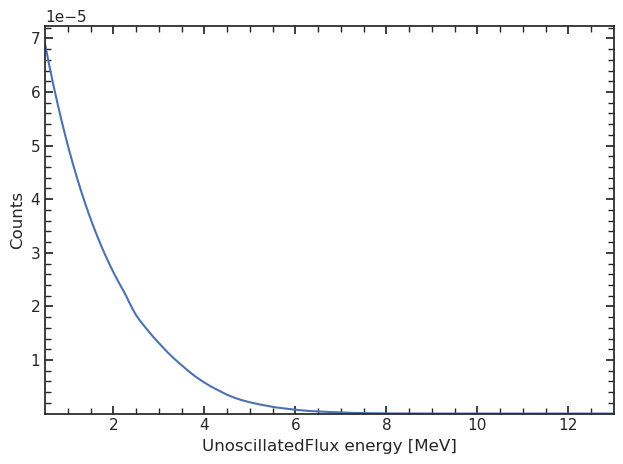

In [18]:
# load the default reactor UnoscillatedSpectrum (Huber-Mueller). You can create your own generator if needed
# if xs is not provided the generator returns an UnoscillatedFlux without XS, which will be applied during in detector response
# if xs is provided the generator applies it and directly returns an UnoscillatedSpectrum. XS will not be applied by detector response
sp_uno_rea = orsa.generator.reactor('HM', isPDF, xs = None).get_spectrum(E_eval)
sp_uno_rea

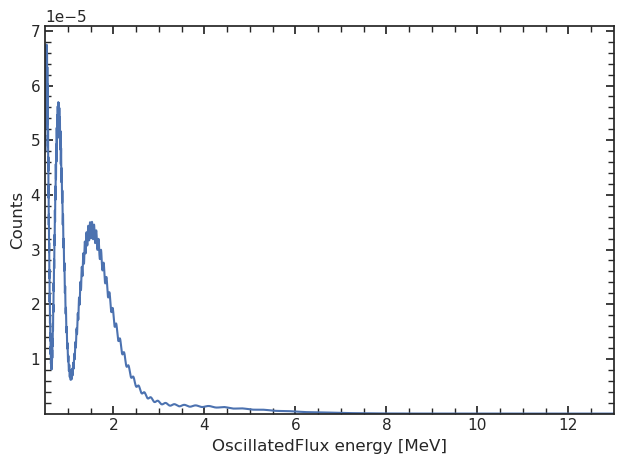

In [19]:
# apply oscillations. It will return the OscillatedSpectrum
sp_osc_rea = osc.oscillate(sp_uno_rea)
sp_osc_rea

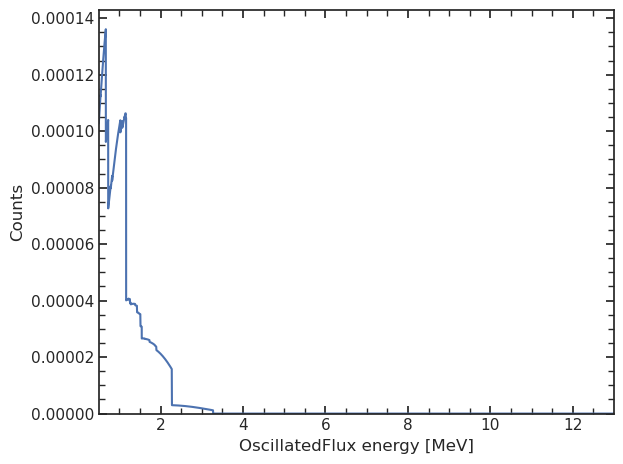

In [20]:
# load geoneutrino OscillatedSpectra.
sp_osc_U = orsa.generator.geoneutrinos('238U', isPDF = isPDF).get_spectrum(E_eval)
sp_osc_Th = orsa.generator.geoneutrinos('232Th', isPDF = isPDF).get_spectrum(E_eval)

sp_osc_U

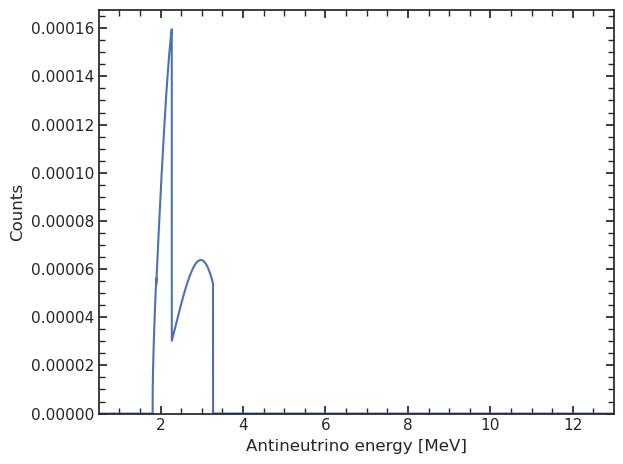

In [21]:
orsa.generator.geoneutrinos('238U', isPDF = isPDF, xs=res.crosssection).get_spectrum(E_eval)

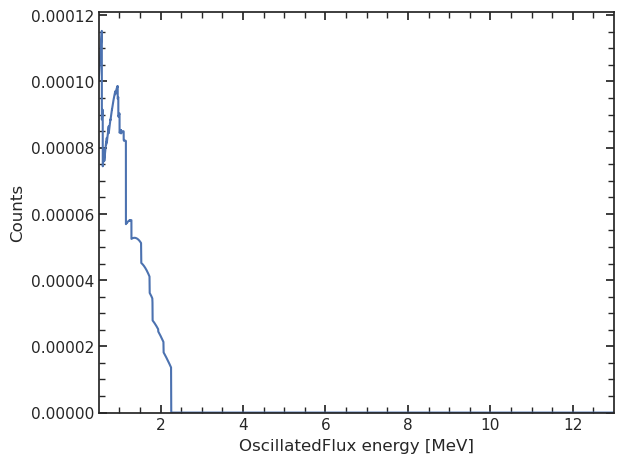

In [22]:
sp_osc_Th

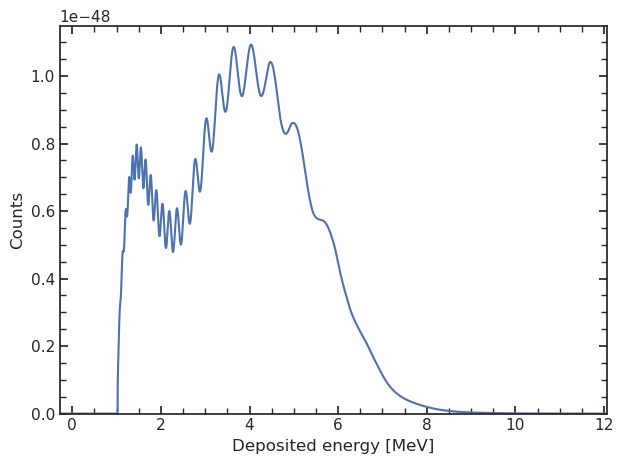

In [23]:
# Make it interact (from antin energy to deposited energy)
sp_dep_rea = res.to_dep(sp_osc_rea)
sp_dep_U = res.to_dep(sp_osc_U)
sp_dep_Th = res.to_dep(sp_osc_Th)

sp_dep_rea

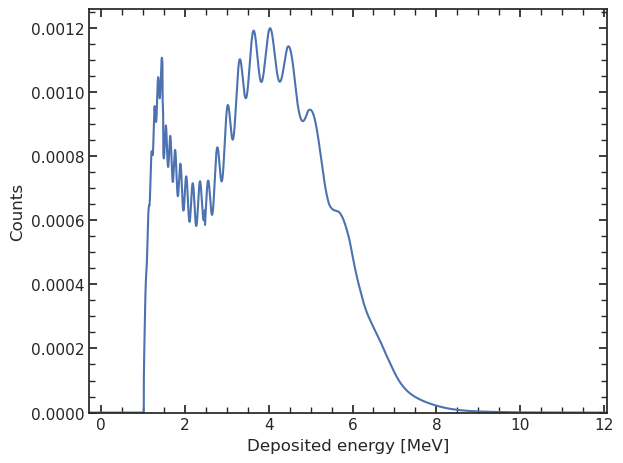

In [24]:
# Spectra of the same type can be scaled and summed 
sp_dep = 45.*sp_dep_rea.norm() + 0.9*sp_dep_U.norm()+0.3*sp_dep_Th.norm()
sp_dep

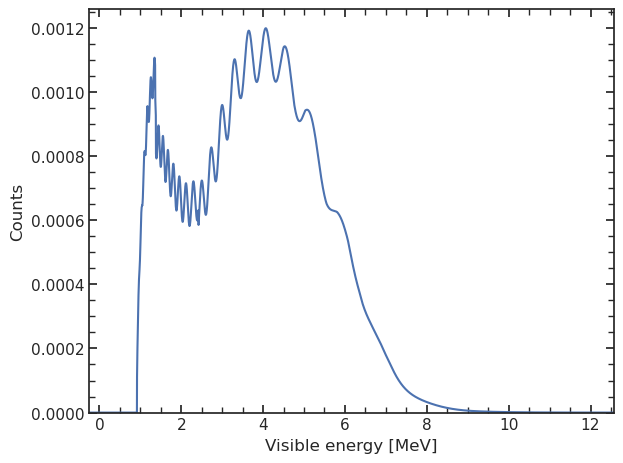

In [25]:
# Apply liquid scintillator non-linearity
sp_vis = res.to_vis(sp_dep)
sp_vis

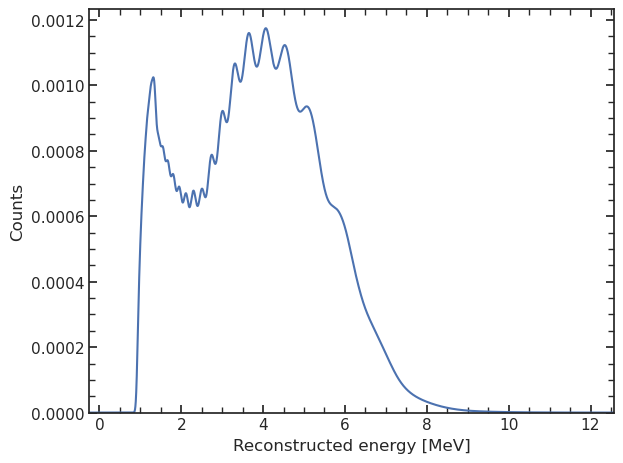

In [26]:
# Apply resolution
sp_rec = res.to_rec(sp_vis)
sp_rec

Text(0, 0.5, 'Entries [A.U.]')

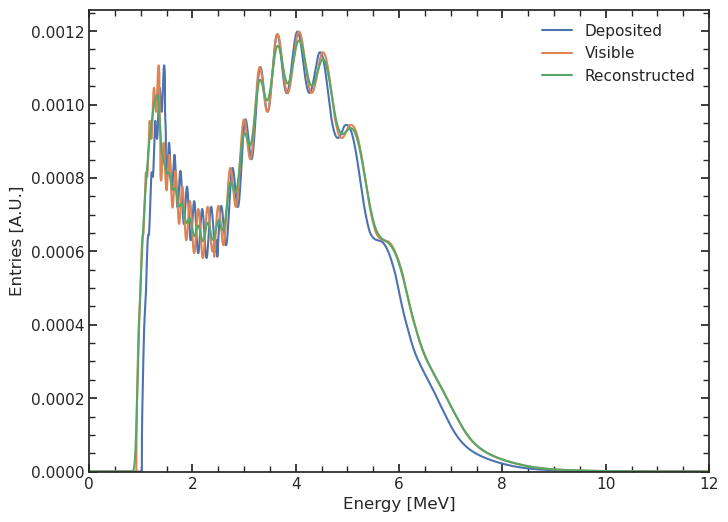

In [27]:
fig, ax = plt.subplots(figsize = (8,6))
ax.plot(sp_dep.E, sp_dep.counts, label = 'Deposited')
ax.plot(sp_vis.E, sp_vis.counts, label = 'Visible')
ax.plot(sp_rec.E, sp_rec.counts, label = 'Reconstructed')

ax.legend(frameon = False)
ax.set_ylim(bottom = False)
ax.set_xlim(0, 12)
ax.set_xlabel('Energy [MeV]')
ax.set_ylabel('Entries [A.U.]')

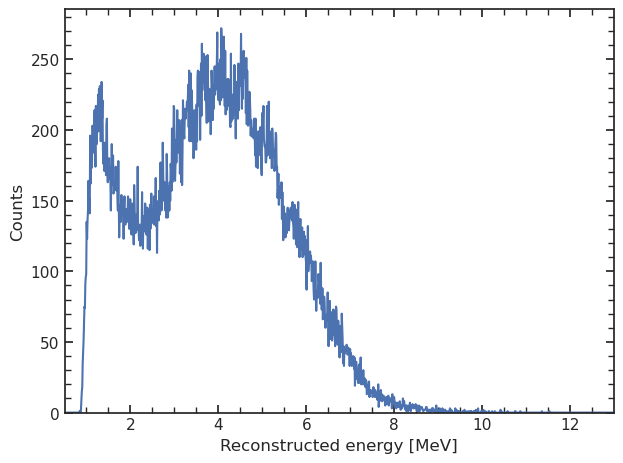

In [28]:
# Run pseudoexperiment for asimov of 100000 events and rebin it (here I group 100 bins to reach 10keV-binning)
asimov = sp_rec.resample(E_eval).norm(100000)
pseudoexperiment = asimov.run_pseudoexperiment().rebin(100)
pseudoexperiment

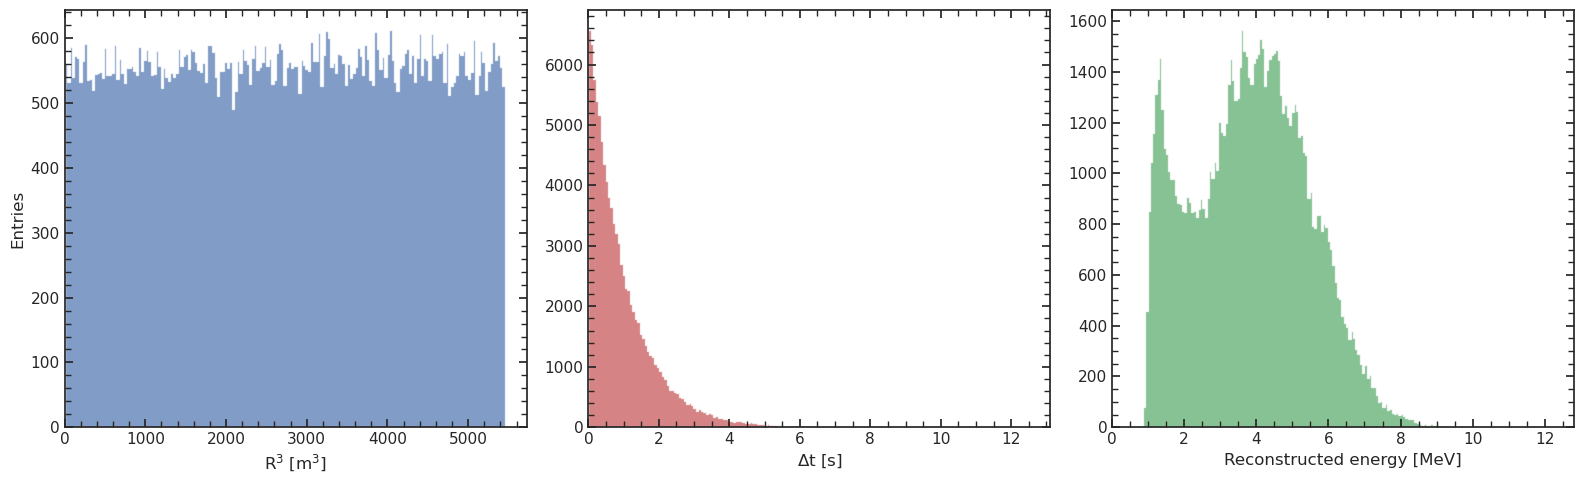

In [29]:
# get list of events for unbinned analysis
samples = asimov.get_samples()

samples

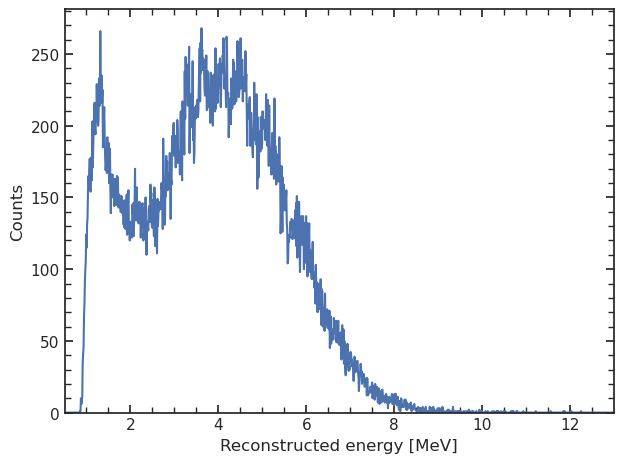

In [30]:
# put events in a histogram to see them
samples.to_hist(bins = pseudoexperiment.Eedges)